## Investigation into model selection metrics, learning curves and model optimization via GridSearch

### 1. Training models and assessing unoptimised model performance

In [56]:
# do the necessary imports
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
warnings.filterwarnings("ignore")
sns.set()

In [57]:
# import scoring and utility functions from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer
from sklearn.datasets import make_blobs

# import 2 models from sklearn. this is what we will compare
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# first generate a 3 class 2 dimensional X, Y values
X, Y = make_blobs(n_samples=1000, n_features=2, centers=3,
                  cluster_std=1.5, random_state=42)
Y = np.reshape(Y, (Y.shape[0], 1))
data = np.concatenate((X, Y), axis=1)
data_df = pd.DataFrame(data, columns=['X1', 'X2', 'label'])

In [67]:
# this function will help us plot the model decision boundaries

def plot_model(data_df, clf):
    
    # first place the points on the chart
    ax = plot_points(data_df)

    # creating a meshgrid and making all combinations of points in 
    # the grid
    r = np.linspace(-15,15,1000)
    s,t = np.meshgrid(r,r)
    
    # reshaping because s is a 2D matrix returned from meshgrid. 
    # have to flatten it to convert to X veector
    s = np.reshape(s,(np.size(s),1)) # x1
    t = np.reshape(t,(np.size(t),1)) # x2
    
    # concatenating along axis=1(column) to convert h into x1,x2 
    # matrix, basically the same thing as the X matrix
    h = np.concatenate((s,t),1)

    z = clf.predict(h)

    s.shape = (np.size(r),np.size(r))
    t.shape = (np.size(r),np.size(r))
    z.shape = (np.size(r),np.size(r))

    # Z HAS to be a 2D array hence reshape all s, t and z
    #ax.contourf(s,t,z,colors = ['green','blue','red'],alpha = 0.2)
    # levels reflects levels in the Z vector plus 1 levels to 
    # represent the initial white canvas that matplotlib paints. 
    # collors are imparted to fill regions acc to the levels sequence
    ax.contourf(s,t,z,alpha = 0.2, levels=[-1,0,1,2], 
                colors=['green', 'blue', 'red'])
    
    # this part draws the black boundary of the contours
    if len(np.unique(z)) > 1:
        plt.contour(s,t,z,colors = 'k', linewidths = 2)

In [59]:
# this function will help us plot learning curves for chosen models

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

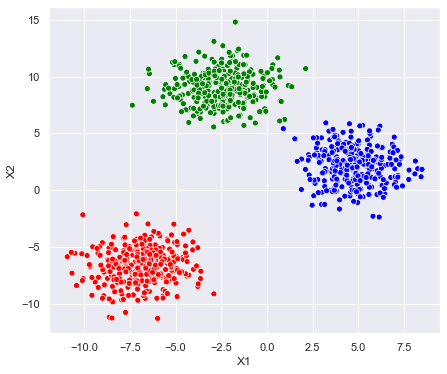

In [68]:
# we will now plot the points generated to get an idea of their spatial distribution
def plot_points(data_df):
    f, ax = plt.subplots(1,1, figsize=(7,6)) # type: _, axes.Axes
    sns.scatterplot(x= 'X1', y='X2', data=data_df, hue='label', ax=ax, 
                    legend=False, 
                    palette={0.0: 'green', 1.0: 'blue', 2.0: 'red'})
    return ax
plot_points(data_df);

In [61]:
# now we will split our features and labels into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=42)

# training an unoptimised decision tree classifier
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(xtrain, ytrain)

# training an unoptimised SVM classifier
clf_svm = SVC(kernel='rbf', gamma=10)
clf_svm.fit(xtrain, ytrain)


# Make predictions using the unoptimized tree model
train_predictions = clf_tree.predict(xtrain)
test_predictions = clf_tree.predict(xtest)

# print the scores
print('The Training F1 Score for DT is', 
      f1_score(ytrain, np.ravel(train_predictions), average='macro'))
print('The Testing F1 Score for DT is', 
      f1_score(ytest, np.ravel(test_predictions), average='macro'))

# Make predictions using the unoptimized svm model
train_predictions = clf_svm.predict(xtrain)
test_predictions = clf_svm.predict(xtest)

# print the scores
print('The Training F1 Score for SVM is', 
      f1_score(ytrain, np.ravel(train_predictions), average='macro'))
print('The Testing F1 Score for SVM is', 
      f1_score(ytest, np.ravel(test_predictions), average='macro'))

The Training F1 Score for DT is 1.0
The Testing F1 Score for DT is 1.0
The Training F1 Score for SVM is 1.0
The Testing F1 Score for SVM is 0.9803564384578795


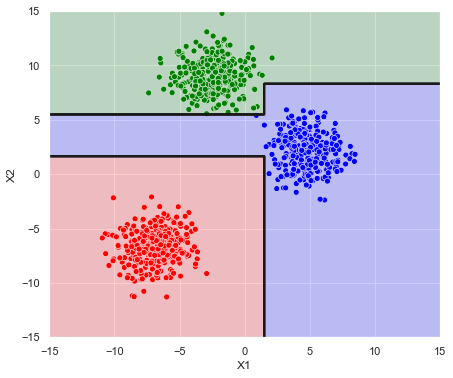

In [63]:
#Now let's plot the decision boundaries of the unoptimised decision tree model
plot_model(data_df, clf_tree)

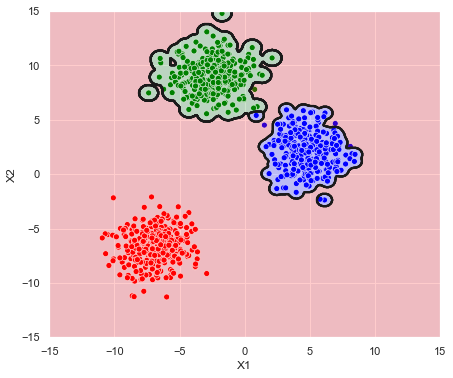

In [64]:
#Now let's plot the decision boundaries of the unoptimised SVM model
plot_model(data_df, clf_svm)

* It can be seen from the f1 score of the decision tree model that it
 achieves an impressive score of 100% on both the training and 
 testing sets.

* The unoptimised SVM model achieves a 98% f1 score on the testing 
  dataset.

* The decision boundaries of the SVM model show that the model is on the 
   verge of being overfit on the training data and hence this opens avenues 
   for model optimisation using GridSearch.

* Let us look at the learning curve of the unoptimised SVM model below to see
    if it infact is doing an overfit on the training dataset.

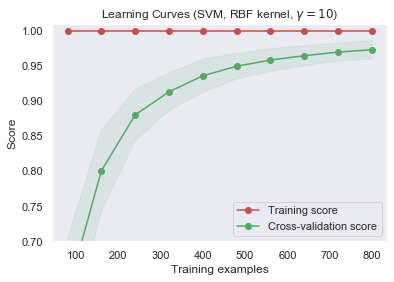

In [65]:
# plot learning curve of unoptimised SVM model
title = r"Learning Curves (SVM, RBF kernel, $\gamma=10$)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(clf_svm, title, X, Y, ylim=(0.7, 1.01),cv=cv, n_jobs=4)
plt.show()

The SVM model learning curve shows good evidence of training dataset overfitting since the traning score and the cross-validation score lines do not converge but seem to be running parallely at higher sizes of tranining datasets. Therefore, we need to optimise the SVM model for which we will implement GridSearch.

### 2. Grid Search

First a gridsearch analysis on the hyperparameters of a decision tree model 
would be done. The goal is to observe if this brings any change to the decision
boundaries seen above for the decision tree model.

The training F1 Score is 0.9973381232229745
The testing F1 Score is 1.0


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

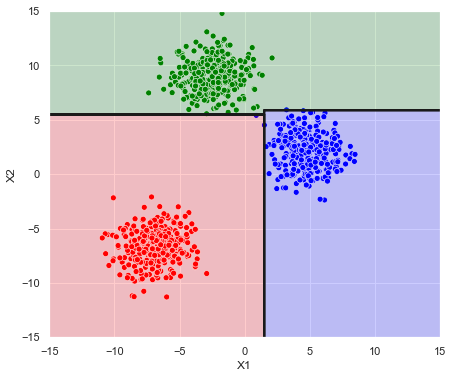

In [25]:
clf = DecisionTreeClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune.
parameters = {'max_depth':[2,4,6,8,10],
              'min_samples_leaf':[2,4,6,8,10], 
              'min_samples_split':[2,4,6,8,10]}

# TODO: Make an fbeta_score scoring object.
#scorer = make_scorer(f1_score, labels=[2], average='weighted')
scorer = make_scorer(f1_score, average='macro')

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters.
grid_fit = grid_obj.fit(xtrain, ytrain)

# Get the estimator.
best_clf = grid_fit.best_estimator_

# Fit the new model.
best_clf.fit(xtrain, ytrain)

# Make predictions using the new model.
best_train_predictions = best_clf.predict(xtrain)
best_test_predictions = best_clf.predict(xtest)

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(ytrain, 
                                           best_train_predictions,
                                           average='macro'))
print('The testing F1 Score is', f1_score(ytest, 
                                          best_test_predictions, 
                                          average='macro'))

# Plot the new model.
plot_model(data_df, best_clf)

# Let's also explore what parameters ended up being used in the new model.
best_clf

The new decision boundaries of the optimised decision tree model seem to be more uniform and better at enclosing the regions of interest. They do less overfitting when compared to the unoptimised model, as shown by the lower training score. Below, we will try to optimise the SVM model using gridsearch.

The training F1 Score is 1.0
The testing F1 Score is 1.0


SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

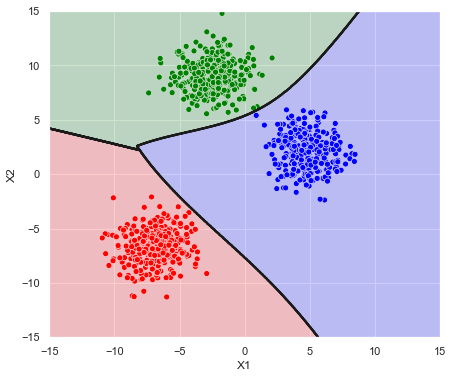

In [26]:
clf = SVC()

# TODO: Create the parameters list you wish to tune.
parameters = {'kernel':['poly', 'rbf'],
              'gamma':[0.01, 0.1, 1, 10, 100, 1000], 
              'C':[0.01, 0.1, 1, 10, 100, 1000]}

# TODO: Make an fbeta_score scoring object.
#scorer = make_scorer(f1_score, labels=[2], average='weighted')
scorer = make_scorer(f1_score, average='macro')

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(clf, parameters, scoring=scorer);

# TODO: Fit the grid search object to the training data and find the optimal parameters.
grid_fit = grid_obj.fit(xtrain, ytrain);

# Get the estimator.
best_clf = grid_fit.best_estimator_;

# Fit the new model.
best_clf.fit(xtrain, ytrain);

# Make predictions using the new model.
best_train_predictions = best_clf.predict(xtrain);
best_test_predictions = best_clf.predict(xtest);

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(ytrain, 
                                           best_train_predictions,
                                           average='macro'))
print('The testing F1 Score is', f1_score(ytest, 
                                          best_test_predictions, 
                                          average='macro'))

# Plot the new model.
plot_model(data_df, best_clf);

# Let's also explore what parameters ended up being used in the new model.
best_clf


It is to be noted that the testing f1 score of the optimised SVM model has now increased to 100%. Moreover, from the decision boundaries of the optimised model, it can be clearly seen that the best model chosen by the gridsearch algorithm for the SVM model is one which generalises to test points better than the previous model because it does not overfit on the training dataset. Hence, we can again check on the optimised SVM model using learning curves to see if the model infact has deviated from training dataset overfitting.

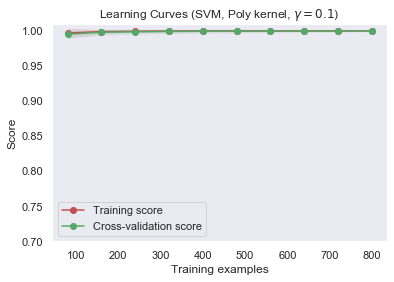

In [66]:
title = r"Learning Curves (SVM, Poly kernel, $\gamma=0.1$)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
plot_learning_curve(best_clf, title, X, Y, ylim=(0.7, 1.01),cv=cv, n_jobs=4)
plt.show()

The learning curve of the new, optimised SVM model show that the training and the cross validation scores converge much earlier. This is a clear testimony to the fact that the optimised model now generalises to test data better and is not an overfit on the training dataset.